# Simulated Annealing for Travelling Salesman Problem

This notebook describes the solution for the travelling salesman problem using simulated annealing.

Given the list of cities in Russia, it is needed to solve the travelling salesman problem for the 30 most populated cities. That is, we need to find the shortest path connecting all 30 cities.

## Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
from time import time
from copy import deepcopy

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import geopy.distance
from shapely.geometry import MultiPolygon, shape

%matplotlib notebook

## Select 30 most populated cities

In [2]:
cities = pd.read_csv('cities.csv')
cities.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000001,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000001,2200,UTC+7,53.347997,83.779806,635585,1730


In [3]:
cities = cities.sort_values(by='population', ascending=False)
top30 = cities.iloc[:30]
top30.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
509,г Москва,101000.0,Россия,Центральный,г,Москва,NaN,NaN,NaN,NaN,...,1,0,45000000000,45000000,7700,UTC+3,55.754047,37.620405,11514330,1147
786,г Санкт-Петербург,190000.0,Россия,Северо-Западный,г,Санкт-Петербург,NaN,NaN,NaN,NaN,...,1,0,40000000000,40000000,7800,UTC+3,59.939131,30.315900,4848742,1703
647,г Новосибирск,630000.0,Россия,Сибирский,обл,Новосибирская,NaN,NaN,г,Новосибирск,...,4,2,50401000000,50701000001,5400,UTC+7,55.028191,82.921149,1498921,1893
832,г Екатеринбург,620000.0,Россия,Уральский,обл,Свердловская,NaN,NaN,г,Екатеринбург,...,4,2,65401000000,65701000001,6600,UTC+5,56.838522,60.605491,1377738,1723
619,г Нижний Новгород,603000.0,Россия,Приволжский,обл,Нижегородская,NaN,NaN,г,Нижний Новгород,...,4,2,22401000000,22701000001,5200,UTC+3,56.324063,44.005391,1250615,1221


For the further convenience, I store only the needed data for the cities: city name, latitude, and longitude

In [4]:
cities = []
for _, r in top30.iterrows():
    cities.append({'address': r['address'], 'coords': (r['geo_lat'], r['geo_lon'])})

## Simulated Annealing

The algorithm is the following:

1. Generate a random path connecting the cities, select initial temperature `T` and annealing rate `anneal_rate`

2. Generate next candidate path: select two cities at random, reverse the path between them

3. With the probability of $p = e^{\frac{old\_path\_length - new\_path\_length}{T}}$ accept the new path as the new state, otherwise leave the old path

4. Update $T = T * (1 - anneal\_rate)$

5. Continue with steps 2-4 until the temperature does not fall down close to 0

6. The resulting state is supposed to be close to the shortest path possible

In [5]:
def generate_random_path(cities):
    '''
    Shuffles the list cities at random
    '''
    return np.random.permutation(cities)

def get_cities_distance(city1, city2):
    '''
    city['coords'] contains a pair (latitude, longitude)
    The function returns the distance in km between the two cities
    '''
    return geopy.distance.geodesic(city1['coords'], city2['coords']).km

def path_dist(cities):
    '''
    Calculate the path length for the consequtive visits of the cities
    '''
    dist = get_cities_distance(cities[0], cities[-1])
    for i in range(1, len(cities)):
        dist += get_cities_distance(cities[i - 1], cities[i])
    return dist

In [6]:
def generate_new_sequence(cities):
    '''
    Generate a new candidate state
    '''
    # choose two cities at random
    ids = sorted(np.random.choice(len(cities), 2, replace=False))
    # detect the cities between which we need to reverse the paths
    new_cities = []
    # add all cities before
#     if ids[1] == len(cities) - 1:
#         new_cities.append(cities[0])
    for i in range(ids[0]):
        new_cities.append(cities[i])
    # add cities in reversed order
    for i in range(ids[1], ids[0] - 1, -1):
        new_cities.append(cities[i])
    # add all cities after
    for i in range(ids[1] + 1, len(cities)):
        new_cities.append(cities[i])
    return new_cities
    
def generate_next_state(cities, T):
    '''
    Generate a new state
    Firstly, generates a candidate state
    Tests whether to accept a new candidate as a next state
    or to leave the previous state
    '''
    proposed = generate_new_sequence(cities)
    prev_dist = path_dist(cities)
    new_dist = path_dist(proposed)
    alpha = np.exp((prev_dist - new_dist) / (T + 1e-14))
    p = np.random.rand(1)[0]
    if p <= alpha:
        return proposed
    else:
        return cities

In [7]:
def run_anneal(cities, T, anneal_rate, reduce_each=1, save_sequence=False):
    '''
    Simulated annealing for the travelling salesman problem
    '''
    count = 0
    state = generate_random_path(cities)
    seq = [state]
    while T > 1:
        state = generate_next_state(state, T)
        count += 1
        if count % reduce_each == 0:
            T = T * (1 - anneal_rate)
        if save_sequence:
            seq.append(state)
    if save_sequence:
        return seq
    return state

### Test for the different annealing rates

For the selected initial temperature $T=1000$ I test 3 different annealing rate values. The lower is the value, the more iterations are run for the simulated annealing, and thus the final state is closer to the most optimal path.

In [8]:
rates = [0.5, 0.05, 0.005]
times = []
dists = []
for rate in rates:
    start = time()
    state = run_anneal(cities, 1000, rate)
    times.append(time() - start)
    dists.append(path_dist(state))

<IPython.core.display.Javascript object>


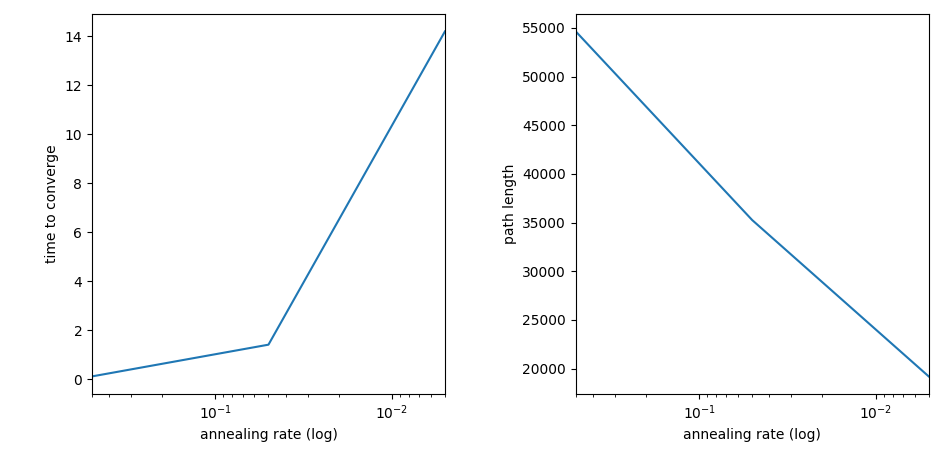

In [9]:
plt.figure()

plt.subplot(121)
plt.plot(rates, times)
plt.xlabel('annealing rate (log)')
plt.xscale('log')
plt.ylabel('time to converge')
plt.xlim(0.5, 0.005)

plt.subplot(122)
plt.plot(rates, dists)
plt.xlabel('annealing rate (log)')
plt.xscale('log')
plt.ylabel('path length')
plt.xlim(0.5, 0.005)

plt.tight_layout()
plt.show()

### Test for the different initial temperatures

For the selected annealing rate $anneal\_rate=0.05$ I test 4 different initial temperature values. The higher is the initial temperature, the more iterations of simulated annealing are run. However, with the extremely high values of initial temperature the solution starts to diverge from the local optimum.

In [10]:
ts = [10, 100, 1000, 10000]
times = []
dists = []
for t in ts:
    start = time()
    state = run_anneal(cities, t, 0.005)
    times.append(time() - start)
    dists.append(path_dist(state))

<IPython.core.display.Javascript object>


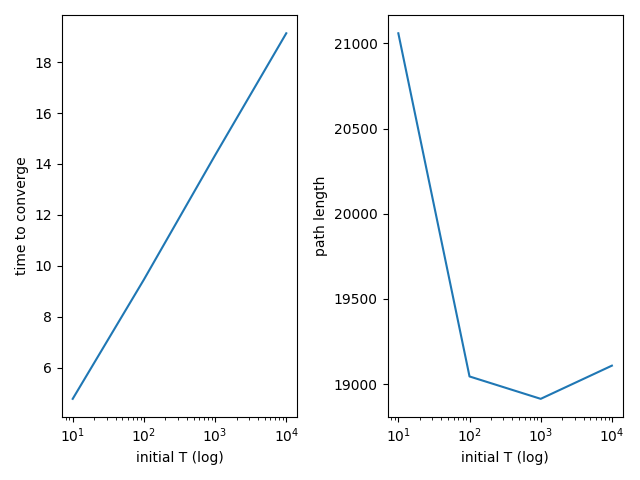

In [11]:
plt.figure()

plt.subplot(121)
plt.plot(ts, times)
plt.xlabel('initial T (log)')
plt.xscale('log')
plt.ylabel('time to converge')

plt.subplot(122)
plt.plot(ts, dists)
plt.xlabel('initial T (log)')
plt.xscale('log')
plt.ylabel('path length')

plt.tight_layout()
plt.show()

## Run the simulated annealing

For the selected values of initial temperature and annealing rate I run the simulated annealing algorithm for the travelling salesman problem. Below you can see the results and the animation of the process of simulated annealing.

In [12]:
states = run_anneal(cities, 1000, 0.005, save_sequence=True)

In [13]:
print(f'The final length of the path is {path_dist(states[-1])}')
print('Suggested path: ')
for city in states[-1]:
    print(f'{city["address"].split()[-1]} -->', end=' ')
print(f'{states[-1][0]["address"].split()[-1]}')

The final length of the path is 19198.25495019262
Suggested path: 
Уфа --> Ижевск --> Казань --> Ульяновск --> Ярославль --> Новгород --> Санкт-Петербург --> Москва --> Воронеж --> Краснодар --> Ростов-на-Дону --> Махачкала --> Волгоград --> Саратов --> Тольятти --> Самара --> Оренбург --> Челябинск --> Омск --> Барнаул --> Новокузнецк --> Иркутск --> Владивосток --> Хабаровск --> Красноярск --> Кемерово --> Новосибирск --> Тюмень --> Екатеринбург --> Пермь --> Уфа


### Generate the visualization

In [14]:
with open('russia.json', 'r') as f:
    russia_map = json.load(f)
    
coords = russia_map[0]['geojson']['coordinates']
    
new_coords = deepcopy(coords)
for i in range(len(new_coords)):
    for j in range(len(new_coords[i][0])):
        if new_coords[i][0][j][0] < 0:
            new_coords[i][0][j][0] = new_coords[i][0][j][0] + 360
            
p = shape({'type': 'MultiPolygon', 'coordinates': new_coords})

<IPython.core.display.Javascript object>


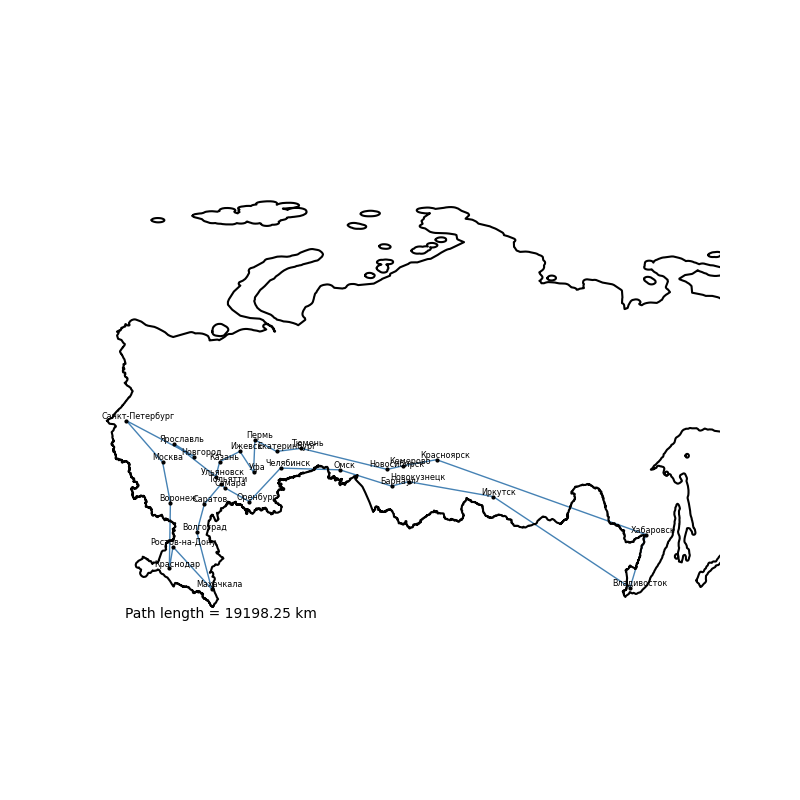

In [15]:
def animate(j):
    x = [states[j][-1]['coords'][1]]
    y = [states[j][-1]['coords'][0]]
    for i in range(30):
        x.append(states[j][i]['coords'][1])
        y.append(states[j][i]['coords'][0])
    line.set_data(x, y)
    dist.set_text(f'Path length = {path_dist(states[j]):.2f} km')
    return line, dist

def init():
    line.set_data([], [])
    dist.set_text('')
    return line,

fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.set_aspect(2)
x = []
y = []
line = ax.plot(x, y, color='steelblue', lw=1)[0]
dist = ax.text(30, 40, '')

for g in p.geoms:
    xs, ys = g.exterior.xy
    ax.plot(xs, ys, color='black')
    
for city in cities:
    ax.plot(city['coords'][1], city['coords'][0], marker='o', markersize=2, color='black')
    ax.text(city['coords'][1] - len(city['address'].split()[-1]) / 3, city['coords'][0] + 0.2, city['address'].split()[-1], fontsize='xx-small')
    

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(states) - 1, interval=20, repeat=False)
      
# anim.save('test.gif', writer='imagemagick')

plt.xlim(25, 150)
plt.axis('off')
plt.show()